In [59]:
from mlp import MultiLayerPerceptron
from TwoDimProblem import TwoDimProblem
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test MLP from other file

In [216]:
p = TwoDimProblem(value_range=5)
X, y = p.createData(soln_rank=2, noise_frac=0.02, samples=1000)

100%|██████████| 50/50 [00:02<00:00, 20.74it/s]


Accuracy = 0.952


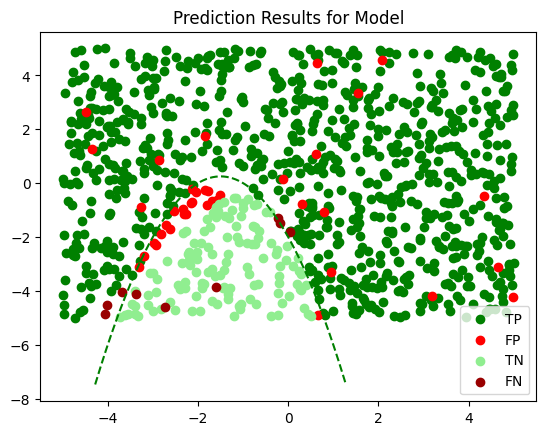

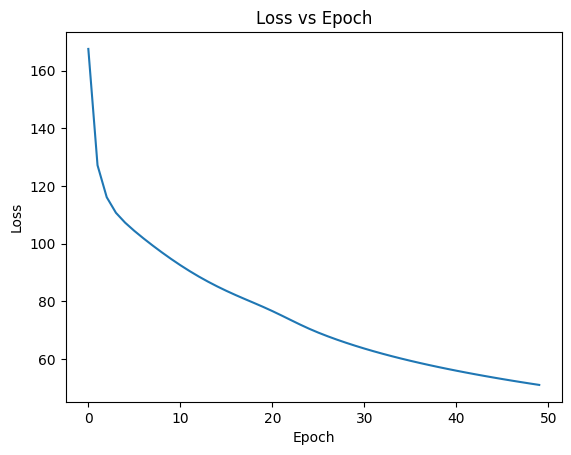

In [220]:

mlp = MultiLayerPerceptron(
    epochs=50, 
    lr=0.1,
    activation='sigmoid',
    # input_layer=2, 
    hidden_layers=[5,3],
    # output_layer=2
    )
    
mlp.fit(X,y, batch_size=10)
pred = mlp.predict(X)
p.plotPred(pred, show_correct=True)
mlp.plot_loss()

Accuracy = 1.0


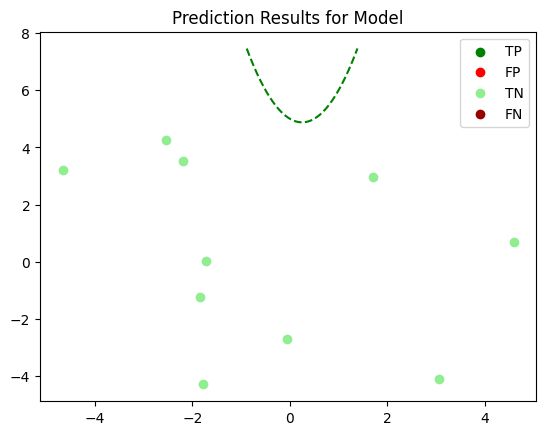

In [136]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(
    hidden_layer_sizes=(3,2),
    activation='logistic',
    solver='sgd',
    learning_rate_init=0.1,
    learning_rate='constant',
    max_iter=50,
    batch_size=1,
)
clf.fit(X,y)
p.plotPred(clf.predict(X), show_correct=True)